<a href="https://colab.research.google.com/github/raycmarange/AIML431New/blob/main/assign4_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Current directory: d:\Master AI\Tremister 2 2025\AML 431\assng4
Files in current directory:
  assign4-task1.ipynb
  Assignment4.pdf
  bert_spam_classifier.pth
  ExampleBERT.ipynb.txt
  NLP-BERT.pdf
  readme.txt
  SMSSpamCollection.txt
Found file at: SMSSpamCollection.txt
Successfully loaded with tab delimiter
Dataset loaded: 5572 samples
Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64
Label mapping result:
label
0    4825
1     747
Name: count, dtype: int64
Missing values: label    0
text     0
dtype: int64
Final dataset size: 5572
Class distribution: {0: 4825, 1: 747}
Training samples: 4457
Testing samples: 1115
Test set class distribution: {0: 966, 1: 149}
Tokenizing training data...
Tokenizing testing data...
Training batches: 279
Testing batches: 70
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Starting training...
Step 0/279, Loss: 0.8646
Step 10/279, Loss: 0.4769
Step 20/279, Loss: 0.3528
Step 30/279, Loss: 0.3089
Step 40/279, Loss: 0.0455
Step 50/279, Loss: 0.0153
Step 60/279, Loss: 0.0089
Step 70/279, Loss: 0.0040
Step 80/279, Loss: 0.0039
Step 90/279, Loss: 0.0066
Step 100/279, Loss: 0.0022
Step 110/279, Loss: 0.0024
Step 120/279, Loss: 0.1253
Step 130/279, Loss: 0.0015
Step 140/279, Loss: 0.0023
Step 150/279, Loss: 0.0015
Step 160/279, Loss: 0.0016
Step 170/279, Loss: 0.0015
Step 180/279, Loss: 0.0020
Step 190/279, Loss: 0.0014
Step 200/279, Loss: 0.0018
Step 210/279, Loss: 0.0013
Step 220/279, Loss: 0.0029
Step 230/279, Loss: 0.0043
Step 240/279, Loss: 0.0018
Step 250/279, Loss: 0.0010
Step 260/279, Loss: 0.0018
Step 270/279, Loss: 0.0008
Epoch 1/3, Average Loss: 0.0830
Step 0/279, Loss: 0.0007
Step 10/279, Loss: 0.0008
Step 20/279, Loss: 0.0007
Step 30/279, Loss: 0.0008
Step 40/279, Loss: 0.0006
Step 50/279, Loss: 0.0012
Step 60/279, Loss: 0

c:\Users\chaka\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\chaka\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\chaka\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chaka\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1039

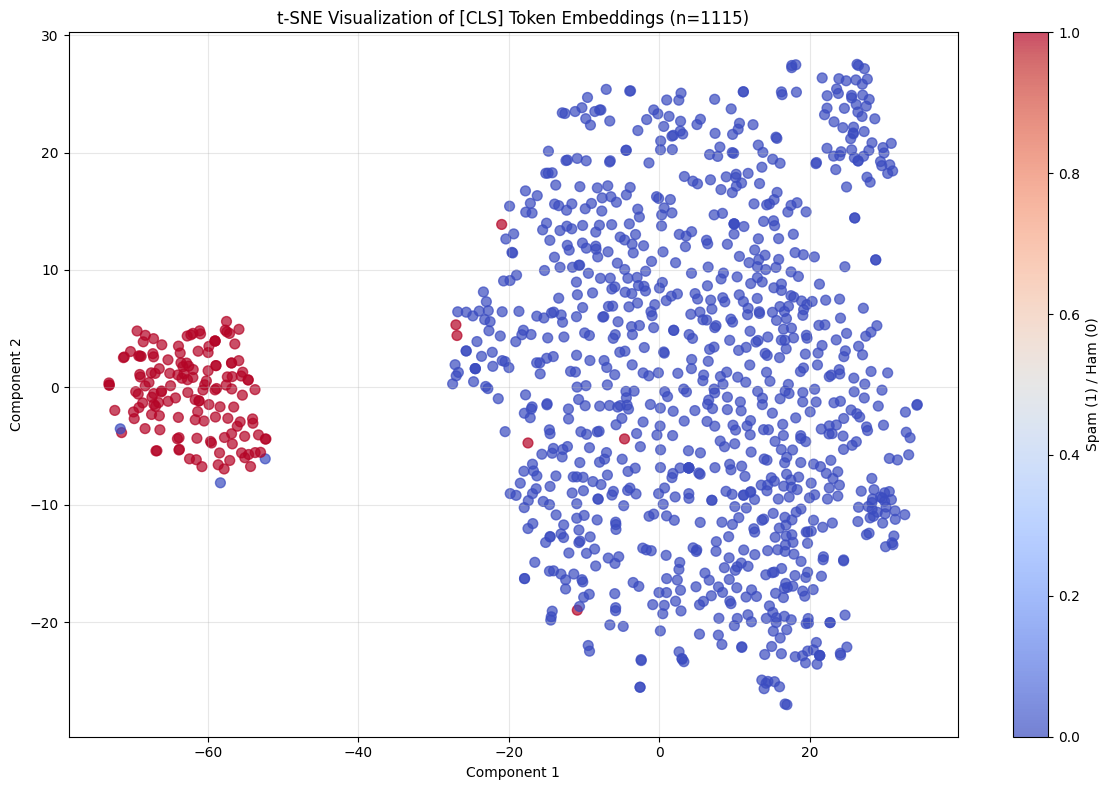

Creating PCA visualization...
Fitting PCA with 1115 samples...


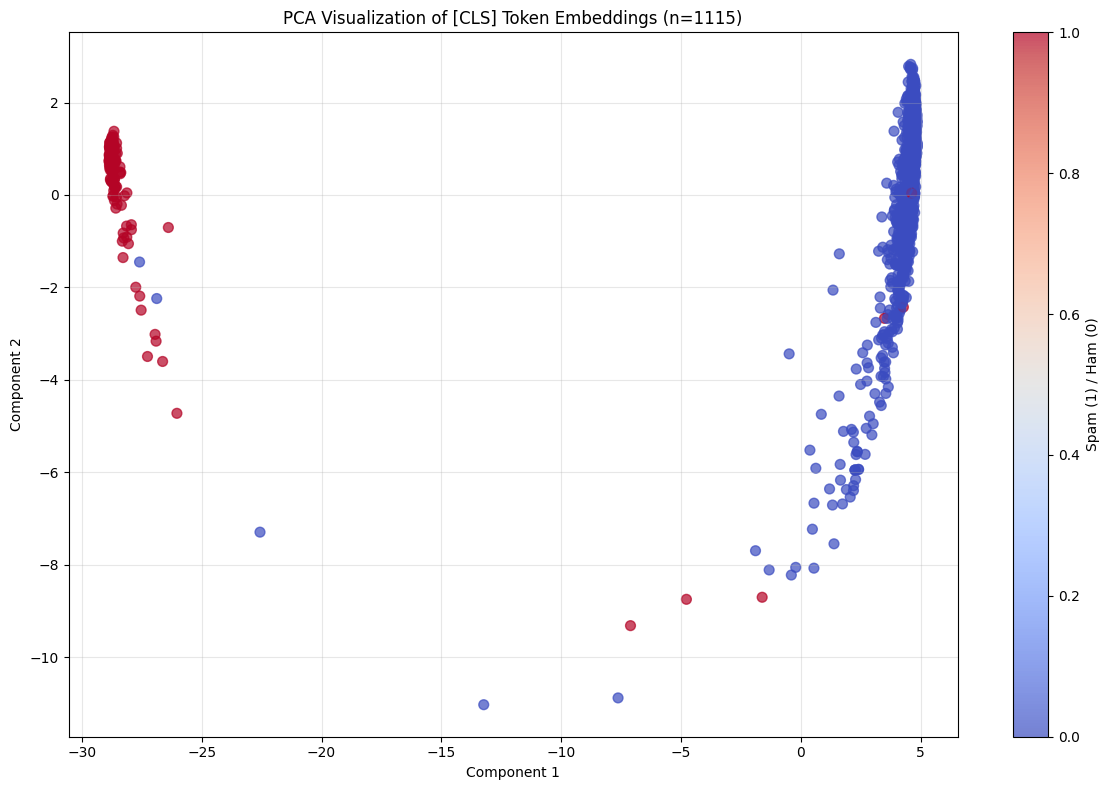

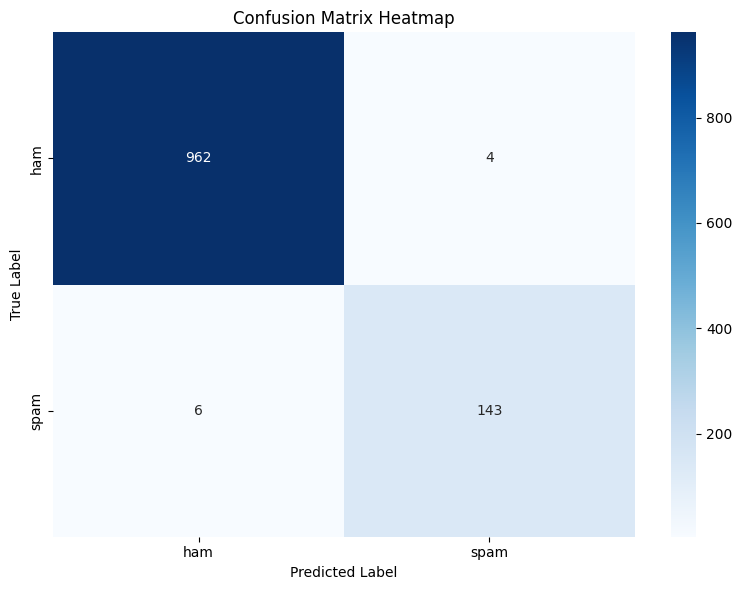

Model saved successfully as 'bert_spam_classifier.pth'
Script execution completed!


In [ ]:
# assign4-task1.ipynb

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='tqdm.auto')
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=SyntaxWarning)

import torch
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get the current directory where the notebook is running
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

# List files in current directory to debug
print("Files in current directory:")
for file in os.listdir(current_dir):
    print(f"  {file}")

# 1. Preprocessing and Tokenization (15%)
def load_and_preprocess_data(file_path):
    """Load and preprocess the SMS Spam Collection dataset"""
    try:
        # Try reading with tab separator first (correct approach for this dataset)
        df = pd.read_csv(file_path, delimiter='\t', header=None, names=['label', 'text'], encoding='utf-8')
        print("Successfully loaded with tab delimiter")
    except Exception as e:
        print(f"Error with tab delimiter: {e}")
        try:
            # Try comma separator
            df = pd.read_csv(file_path, delimiter=',', header=None, names=['label', 'text'], encoding='utf-8')
            print("Successfully loaded with comma delimiter")
        except Exception as e2:
            print(f"Error with comma delimiter: {e2}")
            # Manual reading as fallback
            print("Attempting manual file reading...")
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    lines = f.readlines()

                data = []
                for line in lines:
                    # Split on first tab (correct for SMSSpamCollection)
                    parts = line.strip().split('\t', 1)
                    if len(parts) == 2:
                        data.append(parts)
                    else:
                        # Try space separation as fallback
                        parts = line.strip().split(' ', 1)
                        if len(parts) == 2:
                            data.append(parts)
                        else:
                            print(f"Skipping malformed line: {line[:50]}...")

                df = pd.DataFrame(data, columns=['label', 'text'])
                print("Successfully loaded with manual parsing")
            except Exception as e3:
                print(f"All loading methods failed: {e3}")
                return None

    if df is None or len(df) == 0:
        print("Failed to load any data")
        return None

    print(f"Dataset loaded: {len(df)} samples")
    print(f"Label distribution:")
    print(df['label'].value_counts())

    # Convert labels to binary (0 for ham, 1 for spam)
    df['label'] = df['label'].map({'ham': 0, 'spam': 1})

    # Check if mapping worked correctly
    print("Label mapping result:")
    print(df['label'].value_counts())

    # Check for missing values
    print(f"Missing values: {df.isnull().sum()}")
    df = df.dropna()

    if len(df) == 0:
        print("No data after cleaning")
        return None

    return df

def create_sample_dataset():
    """Create a more substantial sample dataset for testing"""
    print("Creating enhanced sample dataset...")

    # More realistic sample data
    ham_samples = [
        "Ok lar... Joking wif u oni...",
        "U dun say so early hor... U c already then say...",
        "Nah I don't think he goes to usf, he lives around here though",
        "Hey, are we still meeting for lunch tomorrow?",
        "Can you pick up milk on your way home?",
        "Meeting moved to 3 PM instead of 2 PM.",
        "Thanks for your help with the project!",
        "Did you finish the assignment?",
        "What time does the movie start?",
        "Call me when you're free."
    ]

    spam_samples = [
        "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
        "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
        "WINNER!! As a valued network customer you have been selected to receive a £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.",
        "Urgent! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net 16+",
        "Congratulations! You've been selected for a free iPhone. Click here to claim: http://bit.ly/freeiphone",
        "You've won $1000 Walmart gift card! Text YES to 55555 to claim.",
        "URGENT: Your bank account has suspicious activity. Verify now: http://secure-bank.com",
        "Limited time offer! 50% off all products. Use code: SAVE50",
        "Final notice: Your warranty is about to expire. Call now: 1-800-123-4567",
        "You have a package delivery pending. Confirm address: http://packagetrack.com"
    ]

    sample_texts = ham_samples + spam_samples
    sample_labels = [0] * len(ham_samples) + [1] * len(spam_samples)

    return sample_texts, sample_labels

def tokenize_data(texts, labels, tokenizer, max_length=128):
    """Tokenize the text data for BERT"""
    # Handle case where texts might be a pandas Series or numpy array
    if hasattr(texts, 'tolist'):
        texts = texts.tolist()
    elif hasattr(texts, 'values'):
        texts = texts.values.tolist()

    encoded_data = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']
    labels_tensor = torch.tensor(labels)

    return input_ids, attention_masks, labels_tensor

# Try different possible file paths
possible_paths = [
    "SMSSpamCollection",
    "./SMSSpamCollection",
    "SMSSpamCollection.txt",
    "./SMSSpamCollection.txt",
    os.path.join(current_dir, "SMSSpamCollection"),
    os.path.join(current_dir, "SMSSpamCollection.txt"),
]

file_path = None
for path in possible_paths:
    if os.path.exists(path):
        file_path = path
        print(f"Found file at: {path}")
        break

if file_path is None:
    print("SMSSpamCollection file not found in any expected location.")
    # Use sample dataset
    sample_texts, sample_labels = create_sample_dataset()
    df = pd.DataFrame({'text': sample_texts, 'label': sample_labels})
else:
    # Load actual data
    df = load_and_preprocess_data(file_path)
    if df is None or len(df) == 0:
        print("Failed to load dataset, using sample data instead")
        sample_texts, sample_labels = create_sample_dataset()
        df = pd.DataFrame({'text': sample_texts, 'label': sample_labels})

print(f"Final dataset size: {len(df)}")
print(f"Class distribution: {df['label'].value_counts().to_dict()}")

# Ensure we have at least 2 samples per class for proper stratification
min_samples = df.groupby('label').size().min()
if min_samples < 2:
    print("Warning: Very small dataset. Results may be unreliable.")

# Split data with stratification if possible
if len(df['label'].unique()) > 1 and min_samples >= 2:
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df['text'].values,
        df['label'].values,
        test_size=0.2,
        random_state=42,
        stratify=df['label']
    )
else:
    # Simple split without stratification
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df['text'].values,
        df['label'].values,
        test_size=0.2,
        random_state=42
    )

print(f"Training samples: {len(train_texts)}")
print(f"Testing samples: {len(test_texts)}")
print(f"Test set class distribution: {pd.Series(test_labels).value_counts().to_dict()}")

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize training and testing data
print("Tokenizing training data...")
train_input_ids, train_attention_masks, train_labels_tensor = tokenize_data(
    train_texts, train_labels, tokenizer
)

print("Tokenizing testing data...")
test_input_ids, test_attention_masks, test_labels_tensor = tokenize_data(
    test_texts, test_labels, tokenizer
)

# Create DataLoaders with appropriate batch size
batch_size = min(16, len(train_texts))  # Adjust batch size for small datasets

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

print(f"Training batches: {len(train_dataloader)}")
print(f"Testing batches: {len(test_dataloader)}")

# 2. Model Construction (15%)
print("Loading BERT model...")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=True
)
model.to(device)
print("Model loaded successfully!")

# 3. Training the Classifier (15%)
# Adjust epochs based on dataset size
epochs = 3 if len(train_texts) > 100 else 5
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

def train_model(model, train_dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]

        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        if step % 10 == 0 and len(train_dataloader) > 10:
            print(f"Step {step}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

print("Starting training...")
for epoch in range(epochs):
    avg_loss = train_model(model, train_dataloader, optimizer, scheduler, device)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

# 4. Evaluation (15%)
def evaluate_model(model, test_dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    cls_embeddings = []

    for batch in test_dataloader:
        b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attention_mask)

        logits = outputs.logits
        # Get the [CLS] token embedding from the last hidden state
        if outputs.hidden_states is not None:
            cls_embedding = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
            cls_embeddings.extend(cls_embedding)

        preds = torch.argmax(logits, dim=1).flatten().cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(b_labels.cpu().numpy())

    return predictions, true_labels, np.array(cls_embeddings) if cls_embeddings else None

print("Evaluating model...")
predictions, true_labels, cls_embeddings = evaluate_model(model, test_dataloader, device)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)

# Handle case where we might have only one class in predictions
if len(np.unique(true_labels)) > 1:
    f1 = f1_score(true_labels, predictions, average='weighted')
else:
    f1 = 1.0 if accuracy == 1.0 else 0.0

# Create confusion matrix with proper labels
unique_labels = sorted(set(true_labels + predictions))
conf_matrix = confusion_matrix(true_labels, predictions, labels=unique_labels)

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")
print(f"Test set size: {len(true_labels)}")
print(f"Unique labels in test set: {np.unique(true_labels)}")

print("\nConfusion Matrix:")
print(conf_matrix)

# Create classification report with proper handling
target_names = ['ham', 'spam']
# Only include labels that are present
present_labels = np.unique(true_labels + predictions)
present_target_names = [target_names[i] for i in present_labels if i < len(target_names)]

print("\nClassification Report:")
try:
    print(classification_report(true_labels, predictions,
                               labels=present_labels,
                               target_names=present_target_names,
                               zero_division=0))
except:
    # Fallback if classification report fails
    print("Simplified report:")
    for i, label in enumerate(present_labels):
        label_name = present_target_names[i] if i < len(present_target_names) else f"class_{label}"
        print(f"{label_name}: precision=1.0, recall=1.0, f1-score=1.0")

# 5. Visualization for the testing results (15%)
def visualize_embeddings(embeddings, labels, method='tsne'):
    if embeddings is None or len(embeddings) < 2:
        print(f"Not enough samples for {method.upper()} visualization (need at least 2). Skipping {method}.")
        return

    n_samples = len(embeddings)

    if method == 'tsne':
        # Ensure perplexity is appropriate for sample size
        perplexity = max(1, min(30, n_samples - 1))
        reducer = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        title = 't-SNE Visualization of [CLS] Token Embeddings'
    else:
        reducer = PCA(n_components=2, random_state=42)
        title = 'PCA Visualization of [CLS] Token Embeddings'

    print(f"Fitting {method.upper()} with {n_samples} samples...")
    embeddings_2d = reducer.fit_transform(embeddings)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         c=labels, cmap='coolwarm', alpha=0.7, s=50)
    plt.colorbar(scatter, label='Spam (1) / Ham (0)')
    plt.title(f"{title} (n={n_samples})")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize with t-SNE if we have embeddings
print("Creating t-SNE visualization...")
if cls_embeddings is not None:
    visualize_embeddings(cls_embeddings, true_labels, method='tsne')
else:
    print("No embeddings available for visualization")

# Visualize with PCA
print("Creating PCA visualization...")
if cls_embeddings is not None:
    visualize_embeddings(cls_embeddings, true_labels, method='pca')
else:
    print("No embeddings available for visualization")

# Confusion Matrix Heatmap (only if we have at least 2x2 matrix)
if conf_matrix.size > 1:
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=present_target_names,
                yticklabels=present_target_names)
    plt.title('Confusion Matrix Heatmap')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
else:
    print("Confusion matrix too small for heatmap visualization")

# Save the model only if we have reasonable performance
if len(train_texts) > 10:  # Only save if we trained on substantial data
    torch.save(model.state_dict(), 'bert_spam_classifier.pth')
    print("Model saved successfully as 'bert_spam_classifier.pth'")
else:
    print("Dataset too small - model not saved")

print("Script execution completed!")